## This notebook focuses on the second part of the PatientOmics framework:

The aim is to organizing clinical time-series data for analysis and visualization, inwhich we perform the following tasks:

    1. We execute a script to generate the initial matrix containing clinical features for 116 patients, specifically on the first day of hospitalization.

    2. We visualize the correlation among laboratory features for potential long COVID patients (N = 116) on their first day of hospitalization, by:
        a. Grouping features based on their laboratory families.
        b. Sorting features by their average similarity distances.

    3. We create a cluster map to visualize data patterns among potential long COVID patients (N = 116).

In [1]:
import os
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np

## Get the clinical features for all patients at one time point (e.g. 1st day of hospitalization)

In [111]:
## Get the clinical features for all patients at one time point (e.g. 1st day of hospitalization)

import os
import pandas as pd

# Read the list of unique patient IDs
dir_path = '/home/jagh/Documents/01_UB/MultiOmiX/patientomics/data/05_data_exploration/01_preprocessing_116_PLCP/'
filename = os.path.join(dir_path, '116_plcp_mv_pseudoid_pid.csv')
df = pd.read_csv(filename, sep=',', header=0)

# Initialize an empty list to store patient DataFrames
patient_dfs = []

## Set the day to be selected
days_col = 1  

# Iterate through the patient IDs
for patient_id in df['pseudoid_pid']:
    dir_lab_path = '/home/jagh/Documents/01_UB/MultiOmiX/patientomics/data/06_clinical_data/lab_data_features/'
    filename = os.path.join(dir_lab_path, f'patient_{patient_id}.csv')

    try:
        # Read the CSV file into a DataFrame for each patient
        df_lab = pd.read_csv(filename, sep=',', header=0)

        # Get the row features for a specific day in 'days' column (e.g., 'days' == 0)
        df_lab_selected_day = df_lab[df_lab['days'] == days_col].copy()

        # Add a column 'patient_id' into the df_lab_selected_day
        df_lab_selected_day['patient_id'] = patient_id

        # Append the patient DataFrame to the list
        patient_dfs.append(df_lab_selected_day)

    except Exception as e:
    # except FileNotFoundError:
        print(f"Error reading patient {patient_id}: {str(e)}")
        continue

# Concatenate all patient DataFrames into one
collection_df = pd.concat(patient_dfs, ignore_index=True)

# Save the resulting DataFrame as a CSV file
output_csv_path = dir_path + '116_plcp_lab_markers_day-' + str(days_col) +'.csv'
collection_df.to_csv(output_csv_path, index=False)

Error reading patient 1001048: [Errno 2] No such file or directory: '/home/jagh/Documents/01_UB/MultiOmiX/patientomics/data/06_clinical_data/lab_data_features/patient_1001048.csv'


In [7]:
import os
import pandas as pd

# Set the directory paths
base_dir = '/home/jagh/Documents/01_UB/MultiOmiX/patientomics'
data_dir = os.path.join(base_dir, 'data')
lab_data_dir = os.path.join(data_dir, '06_clinical_data/lab_data_features')
dicts_dir = os.path.join(data_dir, 'dicts')

# Read the list of unique patient IDs
patient_id_file = os.path.join(base_dir, 'data/05_data_exploration/01_preprocessing_116_PLCP/116_plcp_mv_pseudoid_pid.csv')
df_patient_ids = pd.read_csv(patient_id_file)

# Read the lab markers dictionary
lab_dict_file = os.path.join(dicts_dir, 'lab_data_dict.csv')
df_lab_dict = pd.read_csv(lab_dict_file, index_col=0)

# Create an empty DataFrame for the clinical data
df_lab_markers = pd.DataFrame(index=df_patient_ids['pseudoid_pid'])

print('df_lab_markers:')

# Iterate through the patient IDs
for patient_id in df_lab_markers.index:
    lab_file = os.path.join(lab_data_dir, f'patient_{patient_id}.csv')
    
    try:
        # Read the first row of the CSV file into a DataFrame per patient
        df_lab = pd.read_csv(lab_file, sep=',', nrows=1, header=0)
        
        # Get the time point
        time_point = df_lab['days'].iloc[0]
        
        # Rename and append the laboratory values to df_lab_markers
        df_lab = df_lab.drop(columns=['days'])
        df_lab = df_lab.add_suffix(f'_{time_point}')
        
        df_lab_markers = pd.concat([df_lab_markers, df_lab], axis=1)
    
    # Make an exception for FileNotFoundError
    except FileNotFoundError:
        continue

# Fill NaN values with 0
df_lab_markers = df_lab_markers.fillna(0)

# Save the updated df_lab_markers to a CSV file
updated_lab_markers_file = os.path.join(base_dir, 'data/05_data_exploration/01_preprocessing_116_PLCP/999_116_plcp_lab_markers.csv')
df_lab_markers.to_csv(updated_lab_markers_file, sep=',', header=True, index=True)

# Print some information about the updated dataframe
print('Updated df_lab_markers:')
print(df_lab_markers)
print('Shape:', df_lab_markers.shape)

Updated df_lab_markers:
         ALAT_0  ASAT_0  Basophile_0  Bicarbonat Std._0  Bicarbonat akt._0  \
1000037     0.0     0.0          0.0                0.0                0.0   
1000065     0.0     0.0          0.0                0.0                0.0   
1000066     0.0     0.0          0.0                0.0                0.0   
1000095     0.0     0.0          0.0                0.0                0.0   
1000104     0.0     0.0          0.0                0.0                0.0   
...         ...     ...          ...                ...                ...   
1001260     0.0     0.0          0.0                0.0                0.0   
1001269     0.0     0.0          0.0                0.0                0.0   
1001343     0.0     0.0          0.0                0.0                0.0   
1001362     0.0     0.0          0.0                0.0                0.0   
0          45.0    57.0          0.0                0.0                0.0   

         C-reaktives Protein_0  Eosinop

### Grouped features based on their laboratory family

/home/jagh/anaconda3/envs/patientomics/lib/python3.9/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


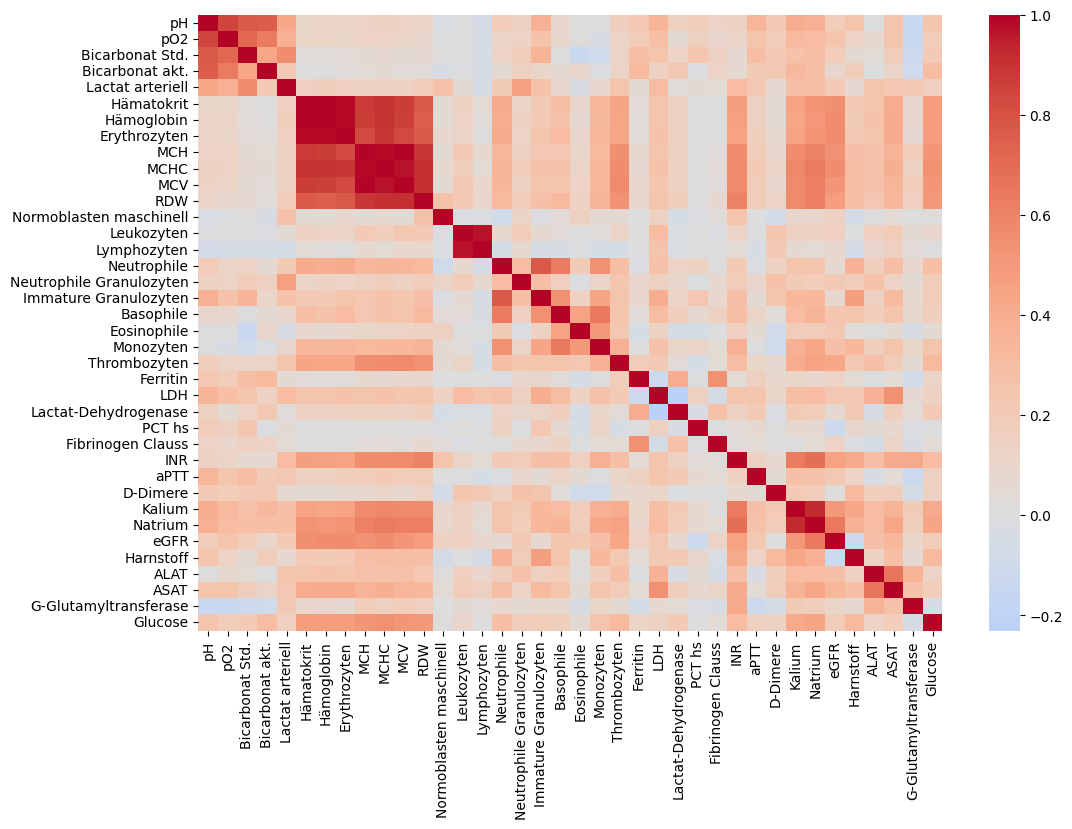

In [2]:
### Grouped features based on their laboratory family

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
from sklearn.manifold import MDS

# Load data
dir_path = '/home/jagh/Documents/01_UB/MultiOmiX/patientomics/data/05_data_exploration/01_preprocessing_116_PLCP/'
filename = os.path.join(dir_path, 'lab_data_exploration.csv')
df = pd.read_csv(filename, sep=',', header=0, index_col=0)

# Standardize the data before calculating distances
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

# Calculate pairwise distances using Euclidean distance
similarities = pairwise_distances(scaled_data, metric='euclidean')

# Multidimensional scaling
seed = np.random.RandomState(seed=3)
mds = MDS(n_components=2, max_iter=5000, eps=1e-12, random_state=seed, dissimilarity='precomputed', n_jobs=1, metric=False)
pos = mds.fit_transform(similarities)

# Features as a heatmap
corr = df.corr()

# Set up the matplotlib figure, adjust size
plt.figure(figsize=(12, 8))

# Draw the heatmap using seaborn
sns.heatmap(corr, cmap='coolwarm', annot=False, fmt=".2f", center=0)

plt.show()

### Sort features based on their average similarity distances

/home/jagh/anaconda3/envs/patientomics/lib/python3.9/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


<Axes: >

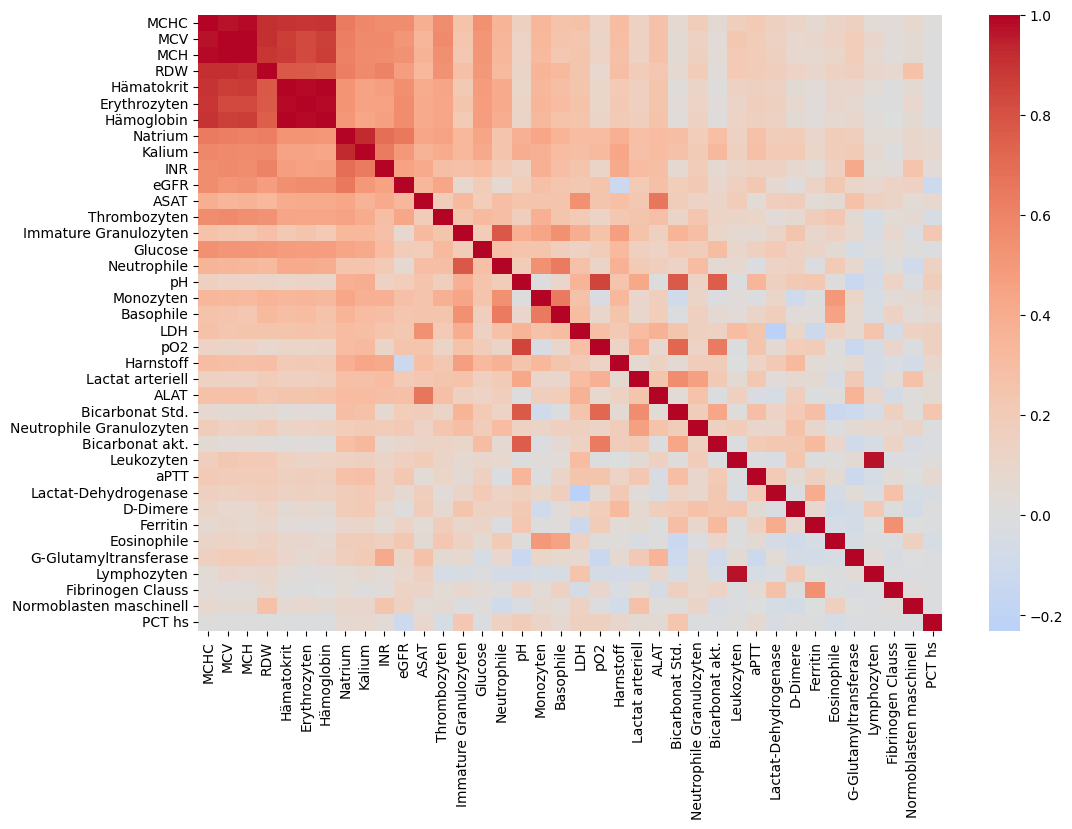

In [3]:
### Sort features based on their average similarity distances

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
from sklearn.manifold import MDS

# Load data
dir_path = '/home/jagh/Documents/01_UB/MultiOmiX/patientomics/data/05_data_exploration/01_preprocessing_116_PLCP/'
filename = os.path.join(dir_path, 'lab_data_exploration.csv')
df = pd.read_csv(filename, sep=',', header=0, index_col=0)

# Standardize the data before calculating distances
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

# Calculate pairwise distances using Euclidean distance
similarities = pairwise_distances(scaled_data.T, metric='euclidean')  # Transpose to get feature distances

# Calculate average similarity distance for each feature
average_distances = np.mean(similarities, axis=0)

# Sort features based on their average similarity distances
sorted_indices = np.argsort(average_distances)
sorted_features = df.columns[sorted_indices]

# Reorder the dataframe columns based on sorted features
sorted_df = df[sorted_features]

# Multidimensional scaling
seed = np.random.RandomState(seed=3)
mds = MDS(n_components=2, max_iter=5000, eps=1e-12, random_state=seed, dissimilarity='precomputed', n_jobs=1, metric=False)
pos = mds.fit_transform(similarities)

# Features as a heatmap
corr = sorted_df.corr()

# Set up the matplotlib figure, adjust size
plt.figure(figsize=(12, 8))

# Draw the heatmap using seaborn
sns.heatmap(corr, cmap='coolwarm', annot=False, fmt=".2f", center=0)


## Cluster map to visualize data patterns among potential long COVID patients (N = 116)

Number of NaN values: 0
Number of infinite values: 0


/home/jagh/anaconda3/envs/patientomics/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/jagh/anaconda3/envs/patientomics/lib/python3.9/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/home/jagh/anaconda3/envs/patientomics/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/jagh/anaconda3/envs/patientomics/lib/python3.9/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=sel

<Figure size 1500x1000 with 0 Axes>

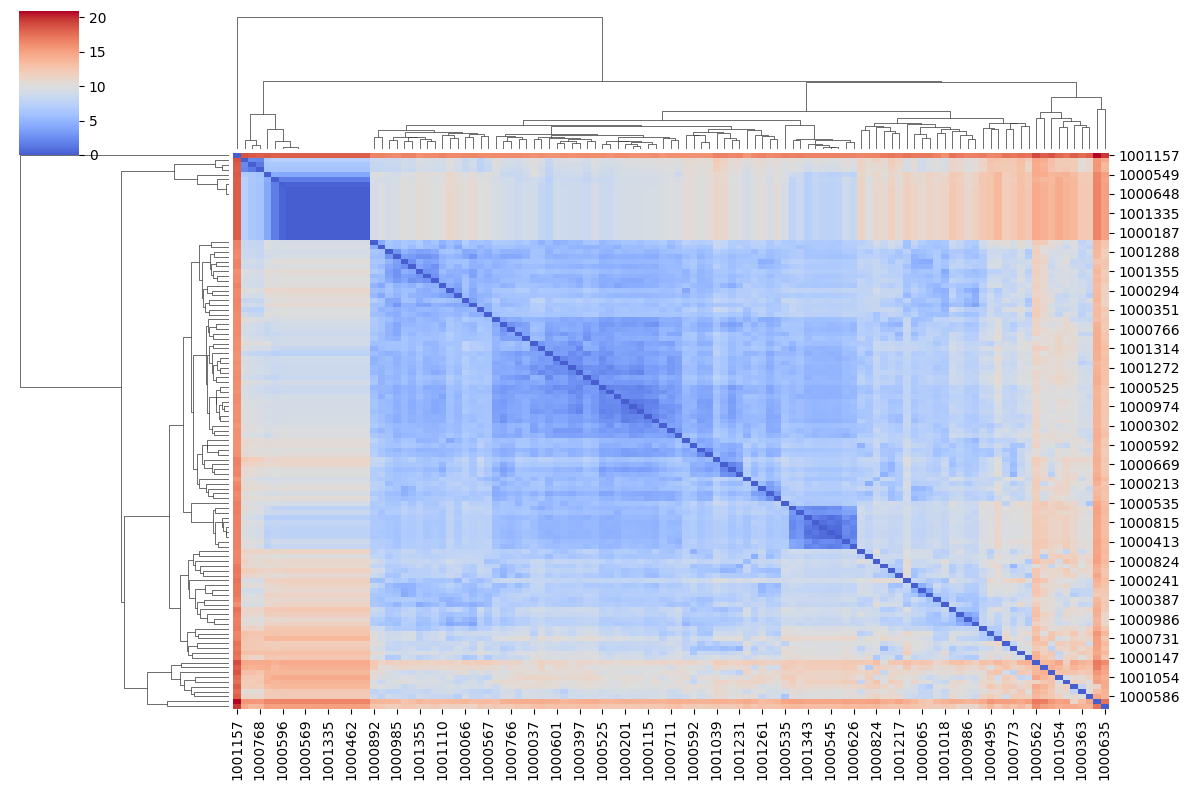

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import euclidean_distances
from sklearn.preprocessing import StandardScaler

# Load data
dir_path = '/home/jagh/Documents/01_UB/MultiOmiX/patientomics/data/05_data_exploration/01_preprocessing_116_PLCP/'
filename = os.path.join(dir_path, 'lab_data_exploration.csv')
df = pd.read_csv(filename, sep=',', header=0, index_col=0)

# Extract the feature columns and sample data
feature_names = df.columns
samples = df.values

# Extract patients ids
patient_ids = df.index.values

# Standardize the data before calculating distances
scaler = StandardScaler()
scaled_samples = scaler.fit_transform(samples)

# Calculate pairwise Euclidean distances
similarities = euclidean_distances(scaled_samples)

# Debugging: Output non-finite values in the similarities matrix
nan_count = np.sum(np.isnan(similarities))
inf_count = np.sum(np.isinf(similarities))
print("Number of NaN values:", nan_count)
print("Number of infinite values:", inf_count)

# Replace NaN with infinity
similarities[np.isnan(similarities)] = np.inf

# Create a DataFrame with the similarities and feature names
similarities_df = pd.DataFrame(similarities, columns=patient_ids, index=patient_ids)

# Set up the matplotlib figure, make it big!
plt.figure(figsize=(15, 10))

# Create a cluster map using seaborn
sns.clustermap(similarities_df, cmap='coolwarm', method='average', metric='euclidean', figsize=(12, 8), center=10)

plt.show()

## Computing the PCA to visualize data patterns among potential long COVID patients (N = 116)

Number of NaN values: 0
Number of infinite values: 0


<Figure size 1500x1000 with 0 Axes>

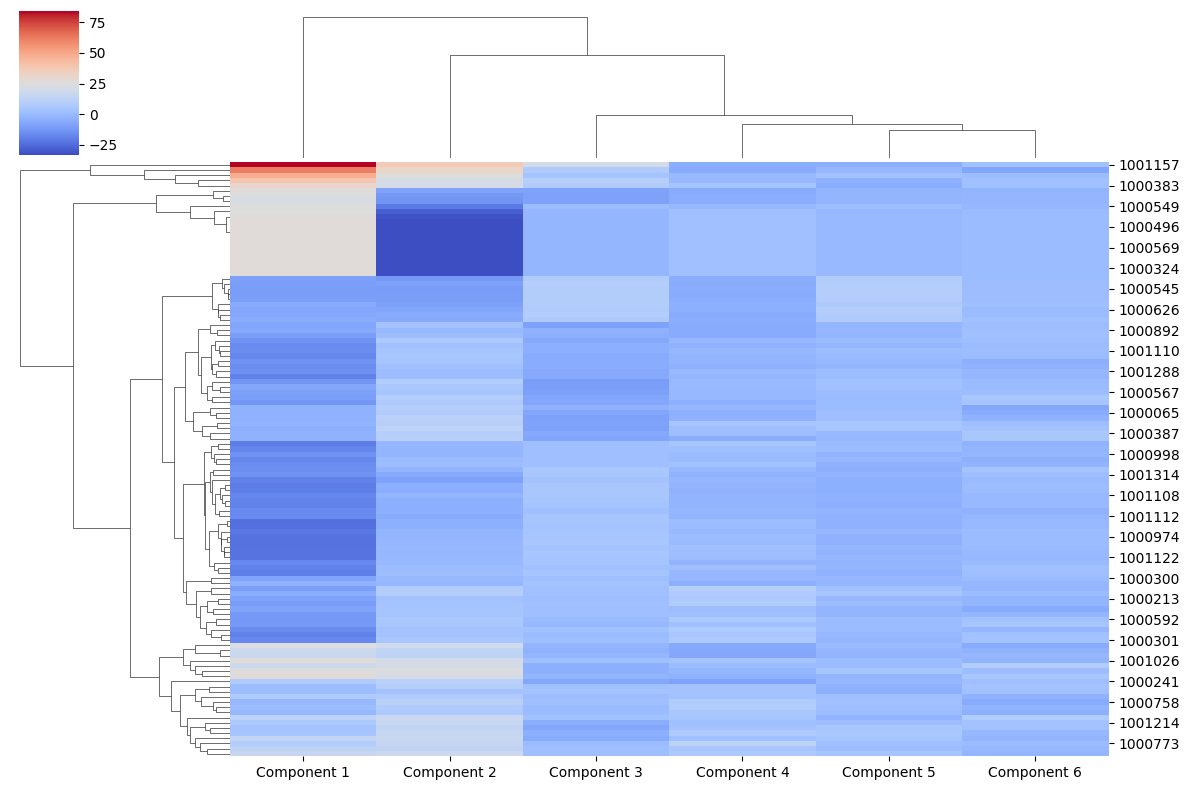

In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import euclidean_distances
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Load data
dir_path = '/home/jagh/Documents/01_UB/MultiOmiX/patientomics/data/05_data_exploration/01_preprocessing_116_PLCP/'
filename = os.path.join(dir_path, 'lab_data_exploration.csv')
df = pd.read_csv(filename, sep=',', header=0, index_col=0)

# Extract the feature columns and sample data
feature_names = df.columns
samples = df.values

# Extract patients ids
patient_ids = df.index.values

# Standardize the data before calculating distances
scaler = StandardScaler()
scaled_samples = scaler.fit_transform(samples)

# Calculate pairwise Euclidean distances
similarities = euclidean_distances(scaled_samples)

# Debugging: Output non-finite values in the similarities matrix
nan_count = np.sum(np.isnan(similarities))
inf_count = np.sum(np.isinf(similarities))
print("Number of NaN values:", nan_count)
print("Number of infinite values:", inf_count)

# Replace NaN with infinity
similarities[np.isnan(similarities)] = np.inf

# Multidimensional scaling
seed = np.random.RandomState(seed=3)
mds = PCA(n_components=6, random_state=seed)  # Using 6 components
pos = mds.fit_transform(similarities)

# Create a DataFrame with the MDS positions and patient IDs
mds_df = pd.DataFrame(pos, columns=[f'Component {i+1}' for i in range(6)], index=patient_ids)

# Set up the matplotlib figure, make it big!
plt.figure(figsize=(15, 10))

# Create a cluster map using seaborn
# sns.clustermap(mds_df, cmap='viridis', method='average', metric='euclidean', figsize=(12, 8))

## Stablish 0 as the center of the heatmap
sns.clustermap(mds_df, cmap='coolwarm', method='average', metric='euclidean', figsize=(12, 8), center=25)

plt.show()

/tmp/ipykernel_40900/1962119126.py:33: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  patient_linkage = hierarchy.linkage(similarities, method='average', metric='euclidean')
/tmp/ipykernel_40900/1962119126.py:53: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  feature_linkage = hierarchy.linkage(feature_similarities, method='average', metric='euclidean')


<Figure size 1500x1000 with 0 Axes>

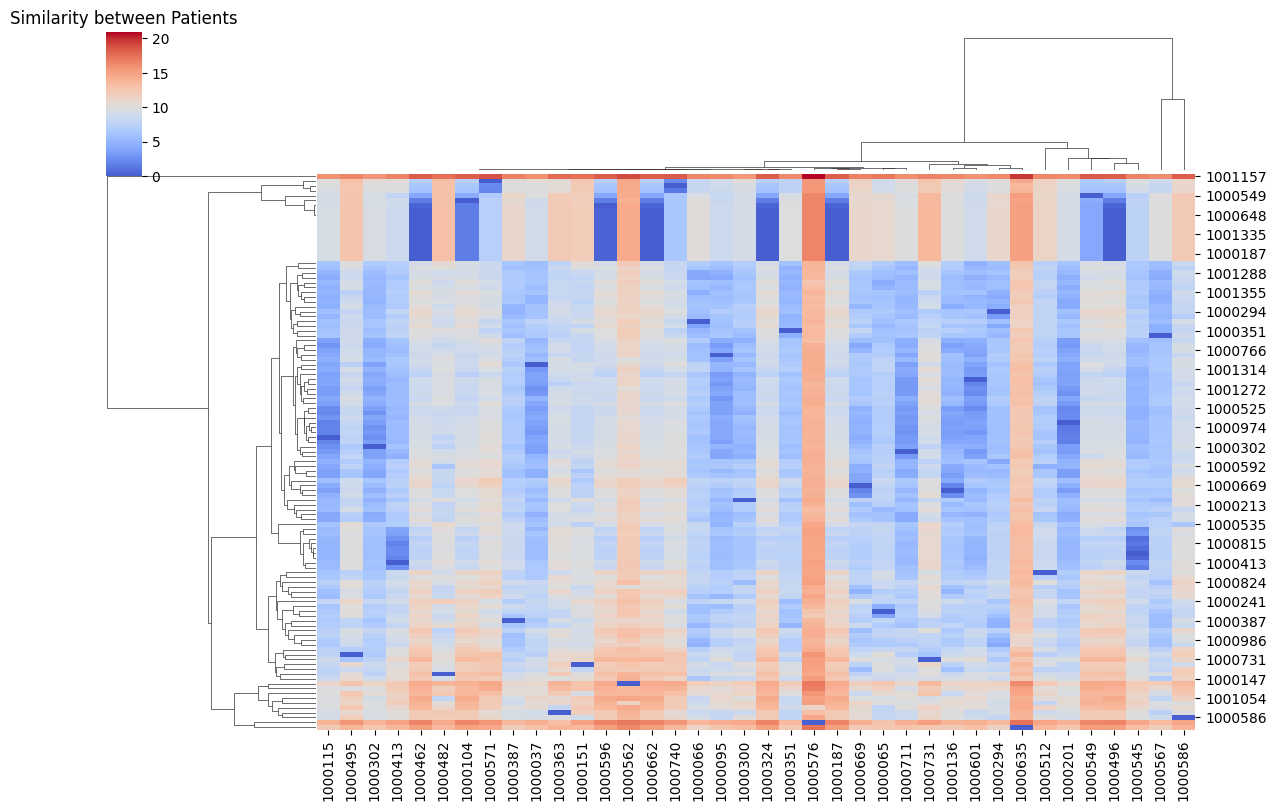

Sorted Feature Names: Index(['Hämatokrit', 'Monozyten', 'Normoblasten maschinell',
       'Immature Granulozyten', 'Basophile', 'Eosinophile', 'Lactat arteriell',
       'INR', 'Neutrophile Granulozyten', 'pH', 'Neutrophile', 'Erythrozyten',
       'Kalium', 'PCT hs', 'Harnstoff', 'Glucose', 'Bicarbonat Std.',
       'Bicarbonat akt.', 'RDW', 'Leukozyten', 'Lymphozyten', 'aPTT', 'MCH',
       'ALAT', 'pO2', 'ASAT', 'G-Glutamyltransferase', 'Hämoglobin', 'Natrium',
       'MCV', 'eGFR', 'Ferritin', 'MCHC', 'Lactat-Dehydrogenase',
       'Thrombozyten', 'LDH', 'Fibrinogen Clauss', 'D-Dimere'],
      dtype='object')


In [6]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import euclidean_distances
from sklearn.preprocessing import StandardScaler
from scipy.cluster import hierarchy

# Load data
dir_path = '/home/jagh/Documents/01_UB/MultiOmiX/patientomics/data/05_data_exploration/01_preprocessing_116_PLCP/'
filename = os.path.join(dir_path, 'lab_data_exploration.csv')
df = pd.read_csv(filename, sep=',', header=0, index_col=0)

# Extract the feature columns and sample data
feature_names = df.columns
samples = df.values

# Extract patients ids
patient_ids = df.index.values

# Standardize the data before calculating distances
scaler = StandardScaler()
scaled_samples = scaler.fit_transform(samples)

# Calculate pairwise Euclidean distances
similarities = euclidean_distances(scaled_samples)

# Replace NaN with infinity
similarities[np.isnan(similarities)] = np.inf

# Calculate linkage for hierarchical clustering of patients
patient_linkage = hierarchy.linkage(similarities, method='average', metric='euclidean')

# Get the order of patients based on the clustering
patient_order = hierarchy.leaves_list(patient_linkage)

# Sort patient IDs according to the clustering order
sorted_patient_ids = patient_ids[patient_order]

# Create a DataFrame with the similarities and sorted patient IDs
# similarities_df = pd.DataFrame(similarities, columns=sorted_patient_ids, index=sorted_patient_ids)
# similarities_df = pd.DataFrame(similarities, columns=sorted_patient_ids, index=sorted_patient_ids)
similarities_df = pd.DataFrame(similarities, columns=patient_ids, index=patient_ids)

# Calculate the similarity matrix for features
feature_similarities = euclidean_distances(samples.T)

# Replace NaN with infinity
feature_similarities[np.isnan(feature_similarities)] = np.inf

# Calculate linkage for hierarchical clustering of features
feature_linkage = hierarchy.linkage(feature_similarities, method='average', metric='euclidean')

# Get the order of features based on the clustering
feature_order = hierarchy.leaves_list(feature_linkage)

# Sort feature names according to the clustering order
sorted_feature_names = feature_names[feature_order]

# Set up the matplotlib figure, make it big!
plt.figure(figsize=(15, 10))

# Create a cluster map using seaborn
sns.clustermap(similarities_df, cmap='coolwarm', row_cluster=True, col_cluster=True, center=10,
               row_linkage=patient_linkage, col_linkage=feature_linkage,
               figsize=(12, 8), cbar_pos=(0.02, 0.8, 0.03, 0.18))

# Add sorted feature names to the plot
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title("Similarity between Patients")

# Show the plot
plt.show()

# Display sorted feature names
print("Sorted Feature Names:", sorted_feature_names)